In [8]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [9]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [10]:
# load datasets

dataset = load_clean_sentences('../data/english-portuguese-training-both.pkl')
train = load_clean_sentences('../data/english-portuguese-training.pkl')
validation = load_clean_sentences('../data/english-portuguese-validation.pkl')




In [36]:


# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare porutguese tokenizer
por_tokenizer = create_tokenizer(dataset[:, 1])
por_vocab_size = len(por_tokenizer.word_index) + 1
por_length = max_length(dataset[:, 1])
print('Portuguese Vocabulary Size: %d' % por_vocab_size)
print('Portuguese Max Length: %d' % (por_length))
 
# prepare training data
trainX = encode_sequences(por_tokenizer, por_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
validationX = encode_sequences(por_tokenizer, por_length, validation[:, 1])
validationY = encode_sequences(eng_tokenizer, eng_length, validation[:, 0])
validationY = encode_output(validationY, eng_vocab_size)
 
# define model
model = define_model(por_vocab_size, eng_vocab_size, por_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
fit1 = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_split=0.1, callbacks=callbacks_list, verbose=2)

#fit1 = model.fit(trainX, trainY, epochs=1, batch_size=64, validation_data=(validationX, validationY), callbacks=callbacks_list, verbose=2)


English Vocabulary Size: 1269
English Max Length: 5
Portuguese Vocabulary Size: 2268
Portuguese Max Length: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 8, 256)            580608    
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 5, 1269)           326133    
Total params: 1,957,365
Trainable params: 1,957,365
Non-trainable params: 0
_________________________________________________________________
None
Train on 4500 sam

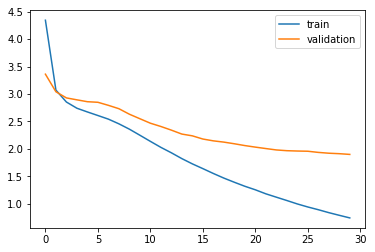

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fit1.history['loss'])
plt.plot(fit1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()